In [1]:
import torch
import sys
import os
from pathlib import Path
sys.path.append(os.path.dirname(os.getcwd()))
from src.models.inference import single_piece_predict
from src.models.models import PKSpell
from src.models.process_score import process_score

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Using", device)

Using cpu


In [2]:
import pandas as pd 
from sklearn.metrics import accuracy_score
import numpy as np
from numpy.random import choice
import matplotlib.pyplot as plt
# plt.style.use(")
import seaborn as sns
from tqdm import tqdm

In [3]:
# !pip install partitura

In [4]:
import partitura

In [5]:
model = torch.load(Path("../models/pkspell.pt"))

## if the load cause problems, loading the state_dict should work
# model = PKSpell()
# model.load_state_dict(torch.load(Path("../models/pkspell_statedict.pt")))

model

PKSpell(
  (rnn): GRU(17, 150, bidirectional=True)
  (rnn2): GRU(300, 12, bidirectional=True)
  (top_layer_pitch): Linear(in_features=300, out_features=36, bias=True)
  (top_layer_ks): Linear(in_features=24, out_features=16, bias=True)
  (loss_pitch): CrossEntropyLoss()
  (loss_ks): CrossEntropyLoss()
)

In [6]:
def abs_path(directory):
    for dirpath,_,filenames in os.walk(directory):
        for f in filenames:
            if f.endswith(".xml"):
                yield os.path.abspath(os.path.join(dirpath, f))
            
fnames = [ _ for _ in abs_path("/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/") ]

In [10]:
partitura.musicxml_to_notearray(fnames[0])

ignoring direction type: metronome {'default-y': '30', 'color': '#000000', 'font-family': 'Opus Text Std', 'font-style': 'normal', 'font-size': '11.9365', 'font-weight': 'normal'}
ignoring direction type: metronome {'default-y': '30', 'color': '#000000', 'font-family': 'Opus Text Std', 'font-style': 'normal', 'font-size': '11.9365', 'font-weight': 'normal'}
ignoring direction type: metronome {'default-y': '30', 'color': '#000000', 'font-family': 'Opus Text Std', 'font-style': 'normal', 'font-size': '11.9365', 'font-weight': 'normal'}


array([( 42., 1. ,  84.,  2.,  21504,  512, 76, 1, 'p0n11'),
       ( 43., 1. ,  86.,  2.,  22016,  512, 76, 1, 'p0n12'),
       ( 44., 0.5,  88.,  1.,  22528,  256, 76, 1, 'p0n13'), ...,
       (438., 1. , 876.,  2., 224256,  512, 44, 1, 'p7n403'),
       (439., 4. , 878.,  8., 224768, 2048, 45, 1, 'p7n404'),
       (443., 8. , 886., 16., 226816, 4096, 40, 1, 'p7n405')],
      dtype=[('onset_beat', '<f4'), ('duration_beat', '<f4'), ('onset_quarter', '<f4'), ('duration_quarter', '<f4'), ('onset_div', '<i4'), ('duration_div', '<i4'), ('pitch', '<i4'), ('voice', '<i4'), ('id', '<U256')])

In [26]:
import glob

In [33]:
midi_path = "/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/midi/"
pattern = "**/*.mid"
midi_fnames = glob.glob(midi_path + pattern, recursive=True)
len(midi_fnames)

1910

In [35]:
! ls $midi_path

Agricola_Alexander     Finzi_Gerald		    Quilter_Roger
Alkan_CharlesValentin  Franz_Robert		    Rachmaninoff_Sergei
Bach_JohannSebastian   Frescobaldi_Girolamo	    Rameau_JeanPhilippe
Balakirev_Mily	       Gesualdo_Carlo		    Ravel_Maurice
Bartok_Bela	       Granados_Enrique		    Reger_Max
Beethoven_Ludwigvan    Grieg_Edvard		    Reichardt_Louise
Binchois_Gilles        Händel_GeorgFriedrich	    Satie_Erik
Brahms_Johannes        Haydn_Joseph		    Scarlatti_Domenico
Busnoys_Antoine        Hensel_Fanny		    Schoenberg_Arnold
Buxtehude_Dietrich     Hummel_JohannNepomuk	    Schubert_Franz
Byrd_William	       Isaac_Henricus		    Schumann_Clara
Chaminade_Cecile       Joplin_Scott		    Schumann_Robert
Chopin_Frederic        Kozeluch_Leopold		    Scriabin_Alexander
Clementi_Muzio	       Lang_Josephine		    Sibelius_Jean
Corelli_Arcangelo      Liszt_Franz		    Strauss_Richard
Cornelius_Peter        Lyapunov_SergeiMikhailovich  Tchaikovsky_Pyotr
Couperin_François      Machaut_Guillaumede	    Vict

In [184]:
def midi2notelist(midi_fname, set_cols=False):
    """
    Converts midi file to note list representation using Temperley's mftext
    """
 
    # notelist = ! mftext/mftext $midi_fname | grep Note
    notelist = ! mftext/mftext $midi_fname | melisma2003/meter/meter \
        | melisma2003/harmony/harmony | grep TPCNote
    
    nl = pd.DataFrame([ n.split() for n in notelist if n.startswith("TPCNote") ])
    
    if set_cols:
        nl.columns = ["Type", "Onset", "Offset", "Pitch"] 
        
        nl["Onset"] = pd.to_numeric(nl["Onset"])
        nl["Offset"] = pd.to_numeric(nl["Offset"])
        nl["Duration"] = nl["Offset"] - nl["Onset"]
        nl["Pitch"] = pd.to_numeric(nl["Pitch"])
        nl["Pitch Class"] = nl["Pitch"] % 12 

    return nl

In [185]:
nls = [] 
errors = []

for f in tqdm(midi_fnames[:10]):
    try:
        nls.append(midi2notelist(f, set_cols=False))
    except:
        errors.append(f)
        pass

100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.71it/s]


In [186]:
len(nls)

10

In [187]:
nls[5]

,0,1,2,3,4
0,TPCNote,0,385,38,4
1,TPCNote,0,385,50,4
2,TPCNote,140,245,53,1
3,TPCNote,245,385,54,8
4,TPCNote,385,490,57,5
...,...,...,...,...,...
1174,TPCNote,96985,97125,62,4
1175,TPCNote,97125,97265,57,5
1176,TPCNote,97265,97370,54,8
1177,TPCNote,97370,97510,50,4


In [22]:
def spelling(fn):
    
    # PATH = "/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/"
    
    notes = partitura.musicxml_to_notearray(fn, include_pitch_spelling=True)
    
    pcs = [ n[-6] % 12 for n in notes]
    durs = [ n[1] for n in notes]    
    tpcs = [ t[-3] for t in notes ]
    
    partitura_est = [ t[0] for t in partitura.musicanalysis.estimate_spelling(notes) ]
    PKSpell_est, sig_est = single_piece_predict(pcs, durs, model, device)
    
    ## mftext
    
    
    df = pd.DataFrame(
        { "tpcs" : tpcs,
         "PKSpell_est" : PKSpell_est,
         "partitura_est" : partitura_est
        }
    )
    
    accs = [accuracy_score(df.tpcs, df.PKSpell_est), accuracy_score(df.tpcs, df.partitura_est) ]
    
    return accs
    

In [9]:
len(fnames)

935

In [144]:
partitura.musicxml_to_notearray(fnames[3])

part-group 1 was not ended


array([( 0. , 4. ,  0. , 4. ,     0, 1024, 60, 1, 'p0n0'),
       ( 0. , 2. ,  0. , 2. ,     0,  512, 55, 1, 'p0n1'),
       ( 2. , 2. ,  2. , 2. ,   512,  512, 57, 1, 'p0n2'),
       ( 4. , 0.5,  4. , 0.5,  1024,  128, 62, 1, 'p0n3'),
       ( 4.5, 0.5,  4.5, 0.5,  1152,  128, 60, 1, 'p0n5'),
       ( 4.5, 1. ,  4.5, 1. ,  1152,  256, 55, 1, 'p0n6'),
       ( 5. , 0.5,  5. , 0.5,  1280,  128, 59, 1, 'p0n7'),
       ( 5.5, 0.5,  5.5, 0.5,  1408,  128, 57, 1, 'p0n8'),
       ( 5.5, 0.5,  5.5, 0.5,  1408,  128, 50, 1, 'p0n9'),
       ( 6. , 0.5,  6. , 0.5,  1536,  128, 57, 1, 'p0n10'),
       ( 6. , 0.5,  6. , 0.5,  1536,  128, 50, 1, 'p0n11'),
       ( 6.5, 1. ,  6.5, 1. ,  1664,  256, 55, 1, 'p0n12'),
       ( 6.5, 1. ,  6.5, 1. ,  1664,  256, 48, 1, 'p0n13'),
       ( 7.5, 0.5,  7.5, 0.5,  1920,  128, 53, 1, 'p0n14'),
       ( 7.5, 0.5,  7.5, 0.5,  1920,  128, 50, 1, 'p0n15'),
       ( 8. , 1. ,  8. , 1. ,  2048,  256, 55, 1, 'p0n16'),
       ( 8. , 2. ,  8. , 2. ,  2048,  512, 52, 1,

In [10]:
N = len(fnames)
pieces = choice(fnames, size=N)

In [11]:
meta = pd.read_csv("data/metadata.csv", sep="\t")
meta.head()

,composer,composer_first,work_group,work catalogue,opus,no,mov,title,composition,publication,...,comment,source,filename,parsed,no_notes,Unnamed: 22,entropy,comp_ID,fifth_width,display_year
0,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,1,NaN,Aime-moi,NaN,1837.0,...,NaN,MS,Un_Morceau_Opus_15_No._1__in_A_Minor_Aime-moi.mxl,1.0,8556.0,NaN,0.549598,1.0,26.0,1837.0
1,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,2,NaN,Le Vent,NaN,1837.0,...,NaN,MS,Un_Morceau_Opus_15_No._2_in_B_Minor_Le_Vent.mxl,1.0,7772.0,NaN,0.234161,1.0,19.0,1837.0
2,Alkan,Charles Valentin,Trois morceaux dans le genre pathétique,Op.,15,3,NaN,Morte,NaN,1837.0,...,NaN,MS,Un_Morceau_Opus_15_No._3_in_E_Minor_Morte.mxl,1.0,9685.0,NaN,0.330321,1.0,21.0,1837.0
3,Alkan,Charles Valentin,Scherzi di bravoure,Op.,16,3,NaN,Etude de Bravour,NaN,1837.0,...,NaN,MS,Etude_de_Bravoure_Opus_16_No._3_in_B_Minor.mxl,1.0,8780.0,NaN,0.323257,1.0,18.0,1837.0
4,Alkan,Charles Valentin,Étude de Concert,Op.,17,NaN,NaN,Le Preux,NaN,1844.0,...,NaN,MS,Etude_de_Concert_pour_Piano_Le_Preux_Opus_17.mxl,1.0,11821.0,NaN,0.294673,1.0,22.0,1844.0


In [12]:
# %%time
# %%capture --no-display
# # to disable warnings

# both_accs = []
# for fn in pieces:
#     if fn.split("/")[-1] in meta["filename"].values:
#         try:
#             date = meta[meta["filename"] == fn.split("/")[-1] ]["display_year"].values.item()
#             both_accs.append(spelling(fn) + [date])
#         except:
#             pass
# both_accs = np.array(both_accs)

CPU times: user 12min 48s, sys: 2.31 s, total: 12min 50s
Wall time: 8min 59s


In [13]:
# len(both_accs) # how many files are actually parsed

883

In [38]:
# df = pd.DataFrame(both_accs, columns=["PKSpell", "ps13", "date"])
# df = df.sort_values(by="date").reset_index(drop=True)
# df.head()

In [28]:
# df.to_csv("accuracies.csv", index=False)

In [37]:
df = pd.read_csv("accuracies.csv")
df.head()

,PKSpell,ps13,date
0,0.932793,1.0,1361.0
1,0.952790,1.0,1361.0
2,0.981707,1.0,1361.0
3,0.932793,1.0,1361.0
4,0.952790,1.0,1361.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


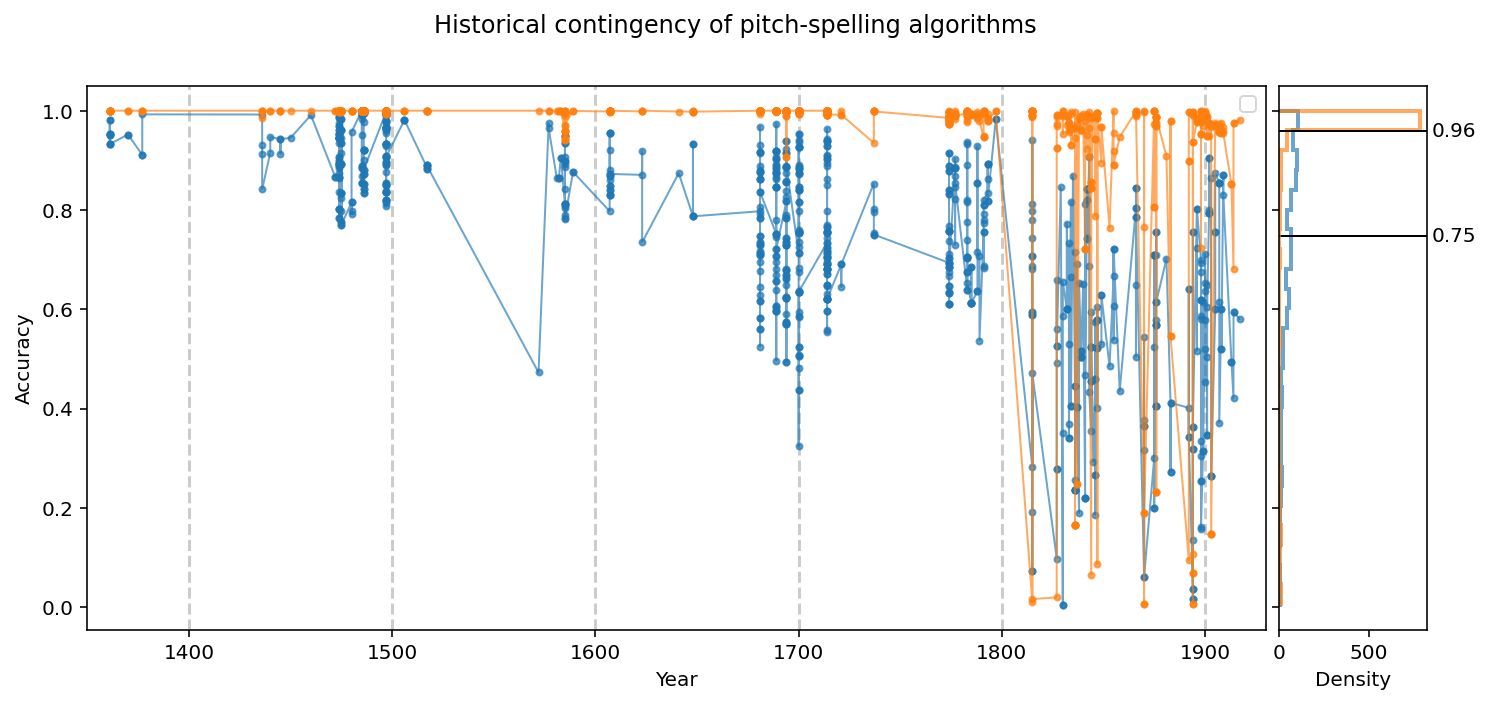

In [87]:
fig, axes = plt.subplots(1,2, figsize=(12,5), 
                       gridspec_kw=dict(width_ratios=[8,1], wspace=0.02), 
                       sharey=True)

# lines

for c in np.linspace(1400,2000,num=7):
    axes[0].axvline(c, ls="--", color="grey", zorder=-3, alpha=.4)
    
axes[0].set_xlim(1350, 1930)
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Accuracy")

axes[0].legend()

## dists

alpha = .66

for col in ["PKSpell", "ps13"]:
    axes[0].plot(df.date, df[col], label=col, lw=1, marker=".", alpha=alpha)
    
    axes[1].hist(
        df[col], 
        label="PKSpell", 
        histtype="step", 
        lw=2, 
        orientation="horizontal",
        alpha=alpha,
        bins=25
    )
    m = df[col].mean()
    axes[1].axhline(m, c="k", lw=1)
    axes[1].text(850, m, str(round(m,2)), va="center")

axes[1].set_xlabel("Density")

fig.suptitle("Historical contingency of pitch-spelling algorithms")
    
plt.show()

In [17]:
df.melt(id_vars="date", var_name="algo", value_name="accuracy")

,date,algo,accuracy
0,1361.0,PKSpell,0.932793
1,1361.0,PKSpell,0.952790
2,1361.0,PKSpell,0.981707
3,1361.0,PKSpell,0.932793
4,1361.0,PKSpell,0.952790
...,...,...,...
1761,1913.0,ps13,0.851429
1762,1914.0,ps13,0.681159
1763,1914.0,ps13,0.975441
1764,1914.0,ps13,0.975441


In [18]:
pieces[32]

'/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/Chopin_Frederic/mazurka63-3.xml'

Dvorak Silhouettes (`'/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/Dvorak_Antonin/Dvorak_8_1.0_0.0.xml'`) is a very interesting case. The accuracy is low because of readbility. The piece switches from C# minor to Db major to avoid to many accidentals. This should be fixable by including some notion of tonal distance.

Similarly, Brahms op 118/6 doesn't notate changes of key (comparable to Liszt notating no key signature).

In [19]:
fn = "/home/fmoss/GitHub/DCMLab/ExtendedTonality/data/scores/Machaut_Guillaumede/Cinc-un-treze_Machaut-Guillaume-de_file1.xml"

In [20]:
spelling(fn)

part-group 1 was not ended


[0.910828025477707, 1.0]

In [21]:
# def PKSpelling(piece):
    
#     PATH = "data/DataFrames/"
    
#     piece = pd.read_csv(PATH + piece, index_col=0)
#     piece = piece[ piece["pitch_class"].notnull() & piece["duration"].notnull() ]

#     tpcs = piece["tpc"].str.replace("b", "-").values
#     pcs = piece["pitch_class"].astype(int).values
#     durs = piece["duration"].values
    
#     # predict
#     pcs_pred, durs_pred = single_piece_predict(pcs, durs, model, device)
    
#     # compare
#     df = pd.DataFrame(
#         { "tpc" : tpcs,
#           "pc" : pcs,
#           "estimate" : pcs_pred,
#           "correct" : tpcs == pcs_pred # maybe replace with metric later
#         }
#     )
    
#     # accuracy 
#     acc = accuracy_score(tpcs, pcs_pred)
    
#     return acc

In [22]:
### So Ger6 chords can't occur?

# midi-numbers % 12
p_list = [7,11,2,5]
# any kind of durations, e.g. seconds, milliseconds, quarterLengths, tatums.
d_list = np.ones(len(p_list))

single_piece_predict(p_list, d_list, model, device)

(['G', 'B', 'D', 'F'], [1, 1, 1, 0])

In [23]:
# class Piece(object):
    
#     def __init__(self, fpath):
#         self.fpath = fpath
#         self.data = pd.read_csv("data/DataFrames/" + self.fpath, index_col=0)
#         self.pc_acc = self.spelling_accuracy()
        
#     def spelling_accuracy(self):
#         from src.models.inference import single_piece_predict
#         from sklearn.metrics import accuracy_score
        
#         model = torch.load(Path("../models/pkspell.pt"))
#         device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        
#         # predict
#         pitch_data = self.data[self.data["pitch_class"].notnull() & self.data["duration"].notnull()]   
#         self.pcs_pred, self.durs_pred = single_piece_predict(pitch_data.pitch_class, pitch_data.duration, model, device)
        
#         return accuracy_score(pitch_data.tpc, self.pcs_pred)
    

In [24]:
# p = Piece(files[0])
# p.spelling_accur()

In [25]:
files = [ f for f in os.listdir("data/DataFrames") if f.endswith(".csv")]
# files = xmls

frames = [ pd.read_csv("data/DataFrames/" + f, index_col=0) for f in files ]

In [26]:
meta = pd.read_csv("data/metadata.csv", sep="\t")
# dates = [ meta[ meta["filename"] == f[:-4] ]["display_year"].values for f in files ]

In [27]:
dates = []
fnames = []

for fr, fi in zip(frames, files):
    date = meta[meta.filename == fi[:-4]]["display_year"].values
    try:
        dates.append(date[0])
        fnames.append(fi)
    except:
        pass

In [17]:
# files = [ f "data/DataFrames/" + for f in os.listdir("data/DataFrames") if f.endswith(".csv")]
N = len(fnames)
pieces = choice(fnames, size=N)

accs = [ PKSpelling(piece) for piece in tqdm(pieces) ]

100%|██████████| 2003/2003 [03:59<00:00,  8.37it/s]


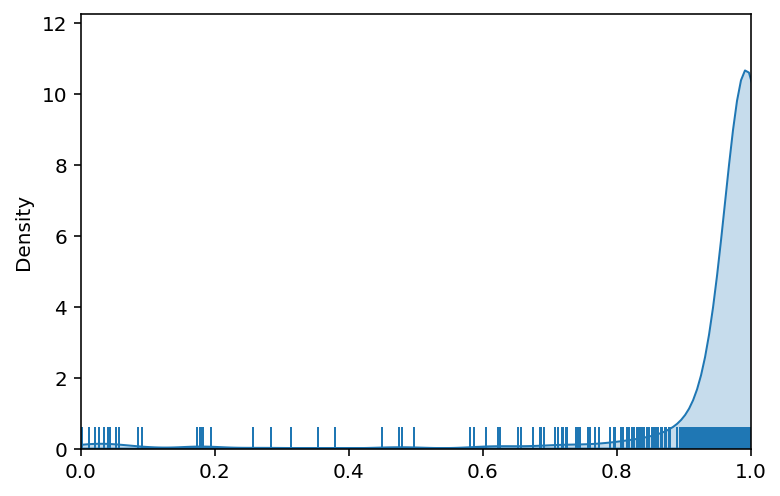

In [18]:
_, ax = plt.subplots()
sns.kdeplot(accs, fill=True, ax=ax)
sns.rugplot(accs, ax=ax, height=.05)

plt.xlim(0,1)
plt.show()

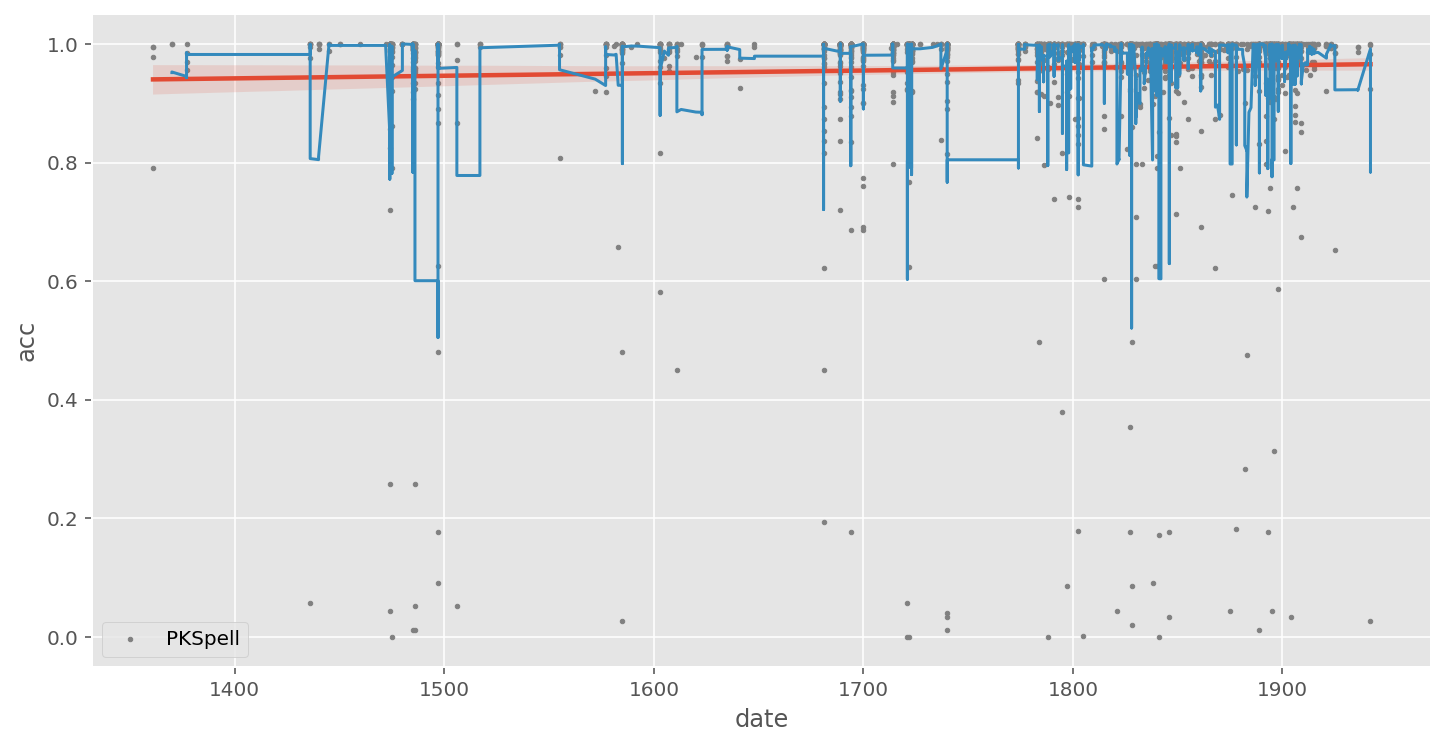

In [27]:
df = pd.DataFrame(
    {
        "date" : dates,
        "acc" : accs
    }
)

df = df.sort_values(by="date").reset_index(drop=True)

# filter "too easy" pieces
# df = df[df.acc < .99]

df["rolling_mean"] = df["acc"].rolling(window=5).mean()

plt.style.use("ggplot")

_, ax = plt.subplots(figsize=(12,6))

x = df.date
y = df.acc

ax.scatter(
    x,
    y,
    s = 5,
    c="gray",
    label = "PKSpell"
)

sns.regplot(
    x=x,
    y=y,
    scatter=False,
    order=1,
    ax=ax)

ax.plot(df.date, df.rolling_mean)

plt.legend()
plt.show()

In [131]:
# for i, d in enumerate(dates):
#     print(i, d)

In [132]:
dates = [ d.values[0] for d in dates ]
dates[:3]

[]

In [133]:
for d in dates:
    try:
        i = d.item()
    except:
        print(d)

In [95]:
len(dates)

1